In [1]:
from D_oblique_decision_trees.evaluation.benchmark_runner import DepthSweepRunner
from src.load_shapes import load_all_shape_datasets

all_data = load_all_shape_datasets()

Starting CSV file loading process from '_data/shapes'...
Data directory set to: ..\_data\shapes

Loaded 'barbell_2d_x.csv' as 'barbell_2d_x' with shape (1500, 2)
Loaded 'barbell_2d_xy_combined.csv' as 'barbell_2d_xy_combined' with shape (1500, 3)
Loaded 'barbell_2d_y.csv' as 'barbell_2d_y' with shape (1500, 1)
Loaded 'barbell_3d_x.csv' as 'barbell_3d_x' with shape (10000, 3)
Loaded 'barbell_3d_xy_combined.csv' as 'barbell_3d_xy_combined' with shape (10000, 4)
Loaded 'barbell_3d_y.csv' as 'barbell_3d_y' with shape (10000, 1)
Loaded 'radial_segment_2d_x.csv' as 'radial_segment_2d_x' with shape (5000, 2)
Loaded 'radial_segment_2d_xy_combined.csv' as 'radial_segment_2d_xy_combined' with shape (5000, 3)
Loaded 'radial_segment_2d_y.csv' as 'radial_segment_2d_y' with shape (5000, 1)
Loaded 'radial_segment_3d_x.csv' as 'radial_segment_3d_x' with shape (10000, 3)
Loaded 'radial_segment_3d_xy_combined.csv' as 'radial_segment_3d_xy_combined' with shape (10000, 4)
Loaded 'radial_segment_3d_y.csv' 

In [ ]:
datasets_2d_dict = {
  "barbell_2d": all_data["barbell_2d"],
  "sine_wave_2d": all_data["sine_wave_2d"],
  "star_2d": all_data["star_2d"],
  "radial_segment_2d": all_data["radial_segment_2d"],
  "rectangle_2d": all_data["rectangle_2d"]
}

# datasets_3d_dict = {
#   "barbell_3d": all_data["barbell_3d"],
#   "radial_segment_3d": all_data["radial_segment_3d"],
#   "saddle_3d": all_data["saddle_3d"]
# }

runner = DepthSweepRunner(datasets_2d_dict, max_depth=7)
df = runner.run()

df = runner.reorder_and_print(df)
runner.plot_results(df, metric="accuracy")            # separate lines per dataset
runner.plot_aggregated_metric(df, metric="accuracy")  # single line per algorithm, averaged across datasets
runner.save_results(df, "my_depth_sweep.csv")

Depth Sweeping:  53%|█████▎    | 74/140 [08:01<29:07, 26.48s/it]

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from src.load_shapes import load_all_shape_datasets

from D_oblique_decision_trees.converters.dispatcher import convert_tree
from D_oblique_decision_trees.visualisation import plot_decision_boundaries, print_tree_structure

from Ensembles_of_Oblique_Decision_Trees.Decision_trees.HouseHolder_CART import HHCartClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.RandCART import RandCARTClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.CO2 import CO2Classifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.Oblique_Classifier_1 import ObliqueClassifier1
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.WODT import WeightedObliqueDecisionTreeClassifier
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.segmentor import MeanSegmentor
from Ensembles_of_Oblique_Decision_Trees.Decision_trees.split_criteria import gini

In [3]:
# Load & scale dataset
datasets = load_all_shape_datasets()
X, y = datasets["barbell_2d"]

Starting CSV file loading process from '_data/shapes'...
Data directory set to: ..\_data\shapes

Loaded 'barbell_2d_x.csv' as 'barbell_2d_x' with shape (1500, 2)
Loaded 'barbell_2d_xy_combined.csv' as 'barbell_2d_xy_combined' with shape (1500, 3)
Loaded 'barbell_2d_y.csv' as 'barbell_2d_y' with shape (1500, 1)
Loaded 'barbell_3d_x.csv' as 'barbell_3d_x' with shape (10000, 3)
Loaded 'barbell_3d_xy_combined.csv' as 'barbell_3d_xy_combined' with shape (10000, 4)
Loaded 'barbell_3d_y.csv' as 'barbell_3d_y' with shape (10000, 1)
Loaded 'radial_segment_2d_x.csv' as 'radial_segment_2d_x' with shape (5000, 2)
Loaded 'radial_segment_2d_xy_combined.csv' as 'radial_segment_2d_xy_combined' with shape (5000, 3)
Loaded 'radial_segment_2d_y.csv' as 'radial_segment_2d_y' with shape (5000, 1)
Loaded 'radial_segment_3d_x.csv' as 'radial_segment_3d_x' with shape (10000, 3)
Loaded 'radial_segment_3d_xy_combined.csv' as 'radial_segment_3d_xy_combined' with shape (10000, 4)
Loaded 'radial_segment_3d_y.csv' 

In [4]:
model_registry = {
    "hhcart": lambda: HHCartClassifier(impurity=gini, segmentor=MeanSegmentor(), max_depth=7),
    "randcart": lambda: RandCARTClassifier(impurity=gini, segmentor=MeanSegmentor(), max_depth=7),
    "oc1": lambda: ObliqueClassifier1(max_depth=7, min_samples_split=2),
    "wodt": lambda: WeightedObliqueDecisionTreeClassifier(max_depth=7, min_samples_split=2, max_features='all')
}

In [5]:
# model_registry = {"co2": lambda: CO2Classifier(impurity=gini, segmentor=MeanSegmentor(), max_depth=8)}

DecisionNode(id=0, depth=0, weights=[0.70995438 0.70424767], bias=-0.4999991174150737)
DecisionNode(id=1, depth=1, weights=[0.68174531 0.73158959], bias=-0.24373731305411425)
LeafNode(id=3, depth=2, prediction=0)
DecisionNode(id=4, depth=2, weights=[0.68456641 0.7289505 ], bias=-0.38440022557773496)
LeafNode(id=9, depth=3, prediction=0)
LeafNode(id=10, depth=3, prediction=0)
DecisionNode(id=2, depth=1, weights=[0.69086759 0.72298131], bias=-0.8321635512829026)
DecisionNode(id=5, depth=2, weights=[0.69548039 0.71854508], bias=-0.675428511520614)
DecisionNode(id=11, depth=3, weights=[ 0.7109478  -0.70324478], bias=-0.4259633178294197)
DecisionNode(id=23, depth=4, weights=[-0.69302481  0.72091373], bias=-0.10894734010650832)
DecisionNode(id=47, depth=5, weights=[0.68382451 0.72964651], bias=-0.5336924657225137)
LeafNode(id=95, depth=6, prediction=0)
DecisionNode(id=96, depth=6, weights=[ 0.74261314 -0.66972063], bias=-0.3101025473835233)
LeafNode(id=193, depth=7, prediction=0)
LeafNode(id

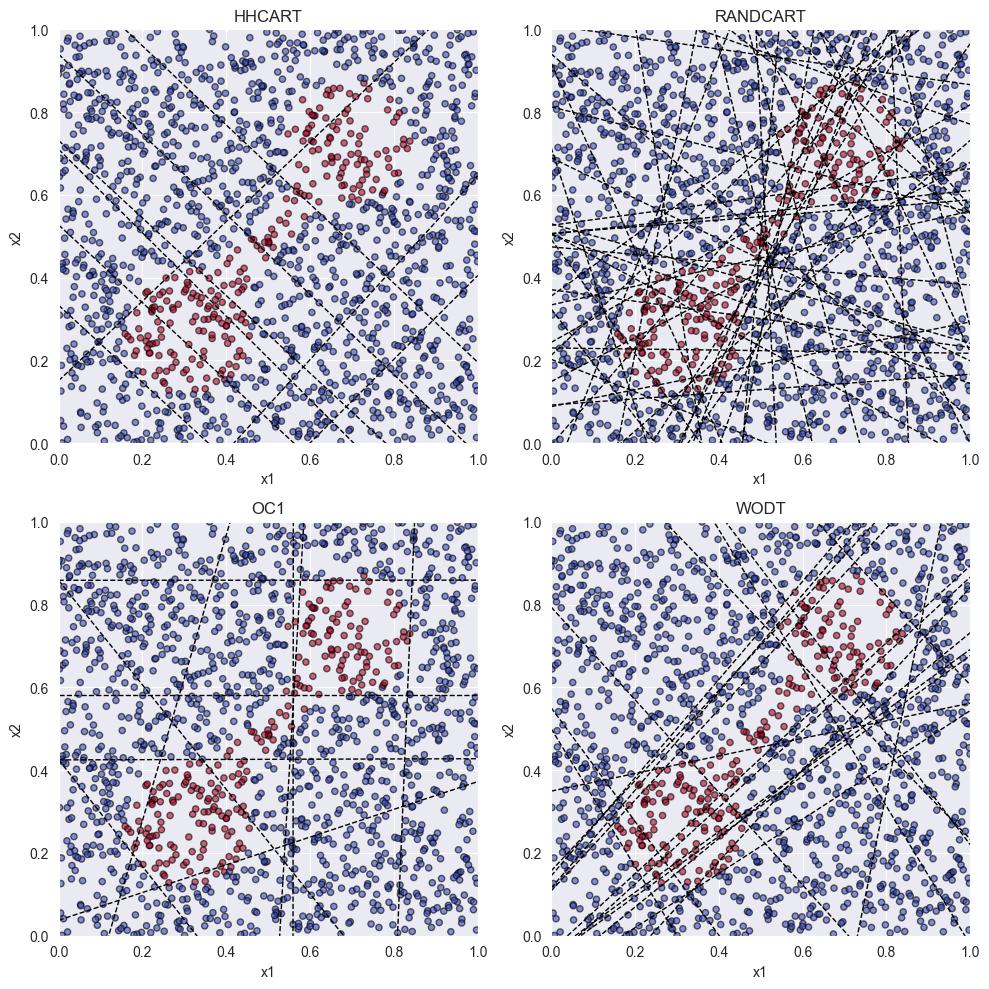

In [6]:
ncols = 2
nrows = (len(model_registry) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, (model_type, constructor) in enumerate(model_registry.items()):
    model = constructor()
    model.fit(X, y)

    tree = convert_tree(model, model_type=model_type)
    ax = axes[i]
    print_tree_structure(tree)
    plot_decision_boundaries(tree, X, y, ax=ax, xlim=(0, 1), ylim=(0, 1))
    # plot_decision_boundaries(tree, X, y, ax=ax, xlim=(-3, 3), ylim=(-3, 3))
    ax.set_title(f"{model_type.upper()}")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from evaluation.evaluator import evaluate_tree
import pandas as pd
import time

# Filter to 2D datasets only
datasets_2d = {name: (X, y) for name, (X, y) in datasets.items() if X.shape[1] == 3}

results = []

for dataset_name, (X, y) in datasets_2d.items():
    for model_name, constructor in model_registry.items():
        print(f"Running {model_name} on {dataset_name}...")
        model = constructor()

        start = time.time()
        model.fit(X, y)
        end = time.time()

        tree = convert_tree(model, model_type=model_name)

        metrics = evaluate_tree(tree, X, y, training_time=end - start)
        metrics["model"] = model_name
        metrics["dataset"] = dataset_name
        results.append(metrics)

df_results = pd.DataFrame(results)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=df_results, x="dataset", y="accuracy", hue="model")
plt.xticks(rotation=45)
plt.title("Model Accuracy per Dataset")
plt.tight_layout()
plt.show()